<a href="https://colab.research.google.com/github/hdemma/hdemma.github.io/blob/master/Macro_Prediction_Models/Prediction_Script_Electric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#global parameters
Vehicle_Type = 'Electric_Vehicles'
#we are not training
Train = False

# Libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from keras.models import load_model
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential,load_model

from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint



In [0]:
#obtain the repository
!git clone https://github.com/hdemma/hdemma.github.io.git 

# Load Data Set

In [13]:
url = 'file:///content/hdemma.github.io/Dataset/Electric_Vehicles/Electric_Vehicles_Final_Training_Samples.csv'
df = pd.read_csv(url)
print(len(df))

57221


# Processsing Inputs and Labels

In [14]:
df = df.values.tolist()
DataSet = np.array(df,dtype=float)

print('*******************************')

Tupple = np.shape(DataSet)                  #57221 Segments x 25 Features
Number_of_Records = Tupple[0]
Number_of_Features = Tupple[1]

print(f'Number_of_Records = {Number_of_Records}')
print(f'Number_of_Features = {Number_of_Features}')


#Processing Sample_Inputs without Target Feature

X = np.zeros((Number_of_Records, Number_of_Features - 1))
for t in range(Number_of_Records):
    X[t] = DataSet[t, :(Number_of_Features-1)]

print(f'Input_Size = {np.shape(X)}')

#Processings Sample_Lables with Target feature ('Fuel_Consumed')

y = np.zeros((Number_of_Records,))
for t in range(Number_of_Records):
    y[t] = DataSet[t][Number_of_Features-1]

print(f'Label_Size = {np.shape(y)}')


print('*******************************')

*******************************
Number_of_Records = 57221
Number_of_Features = 25
Input_Size = (57221, 24)
Label_Size = (57221,)
*******************************


# Random Train-Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f'Training_Input = {np.shape(X_train)}')
print(f'Training_Labels = {np.shape(y_train)}')

print(f'Testing_inputs = {np.shape(X_test)}')
print(f'Testing_Labels = {np.shape(y_test)}')

Training_Input = (45776, 24)
Training_Labels = (45776,)
Testing_inputs = (11445, 24)
Testing_Labels = (11445,)


# Removing Time_Needed Feature

In [16]:
# Saving Time Needed for predicting for samples with longer intervals
Time_needed = []

for i in X_test:
    Time_needed.append(i[1])

print(np.shape(Time_needed))

#Deleting Time_Needed before Training

X_train = np.delete(X_train, 1, 1)
X_test = np.delete(X_test, 1, 1)

print(np.shape(X_train))
print(np.shape(y_train))

T = np.shape(X_test) #For Plotting

print(T)

Length_of_TestData = T[0]

(11445,)
(45776, 23)
(45776,)
(11445, 23)


# ANN Model - Feed Forward

In [0]:
def SimpleFeedForward_Model():

  %cd /content/hdemma.github.io/Dataset/PredictionModels/Electric/
  
  if Train:
    FF_model = Sequential()
    FF_model.add(Dense(100,  input_shape=(Number_of_Features-2,), activation="sigmoid"))
    FF_model.add(Dense(80, activation="sigmoid"))
    FF_model.add(Dense(1, activation = "linear"))

    optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.00001)

    FF_model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mae'])

    FF_model = f'FF_model_{epoch:03d}_{loss:03f}_{val_loss:03f}.h5'
    checkpoint = ModelCheckpoint(f'FF_model_{epoch:03d}_{loss:03f}_{val_loss:03f}.h5', verbose=1, monitor='val_loss',
                                 save_best_only=True, mode='auto')
    
    history = FF_model.fit(X_train, y_train,
        shuffle=True,
        epochs=600,
        batch_size=128,
        # validation_split=0.05,
        validation_data=(X_test,y_test),
        callbacks=[checkpoint],
        verbose=2)



    print(history.history.keys())

    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('mean_squared_error')
    plt.xlabel('Iteration')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Iteration')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    print("Saved model to disk")

    y_pred = FF_model.predict(X_test, verbose=2, batch_size=128)

    return y_pred

  else:
    #### load model

    filename = f'FF_model-ALL-799-0.031906-0.031194.h5'
    FF_model = load_model(filename)

    print("MSE\t\tMAE")

    scores = FF_model.evaluate(X_train, y_train, verbose=2)
    print("Tarining Set Loss: {}".format(scores))

    scores = FF_model.evaluate(X_test, y_test, verbose=2)
    print("Testing Set Loss: {}".format(scores))

    y_pred = FF_model.predict(X_test, verbose=2, batch_size=128)

    return y_pred

# Decision Tree Model

In [0]:
def DecisionTree_Model():
  
  %cd /content/hdemma.github.io/Dataset/PredictionModels/Electric/
  filename = 'finalized_DT_model.sav'
  if Train:
    DT_regressor = DecisionTreeRegressor(max_depth= Number_of_Features,
                                      splitter = 'best',
                                      criterion="mse", min_samples_leaf=0.001)

    DT_regressor.fit(X_train, y_train)

    y_pred = DT_regressor.predict(X_train)

    MSE = np.sum(((y_train - y_pred) ** 2) / len(y_train))
    print(f'MSE on Train = {MSE}')

    y_pred = DT_regressor.predict(X_test)

    MSE = np.sum(((y_test - y_pred) ** 2) / len(y_test))
    print(f'MSE on Test = {MSE}')

    RMSE = np.sqrt(np.sum(((y_test - y_pred) ** 2) / len(y_test)))
    print(f'RMSE = {RMSE}')

    MAE = np.sum(abs(y_test - y_pred) / len(y_test))
    print(f'MAE = {MAE}')
    
    ## save the model to disk
    
    pickle.dump(DT_regressor, open(filename, 'wb'))

    return y_pred

  else:

    loaded_model = pickle.load(open(filename, 'rb'))
    y_pred = loaded_model.predict(X_test)
    score = loaded_model.score(X_test,y_test)
    print(f'R^2 Score = {score}')

    return y_pred

# Linear Regression Model

In [0]:
def LinearRegression_Model():

  %cd /content/hdemma.github.io/Dataset/PredictionModels/Electric/

  filename = f'finalized_LR_model.sav'

  if Train:
    regression_model = LinearRegression(fit_intercept=True, normalize=True)
    
    # fit the regressor
    regression_model.fit(X_train, y_train)
    
    # regression coefficients
    print('Coefficients for each feature:')
    print(regression_model.coef_)
    
    R_Square = regression_model.score(X_test, y_test)  # 1 is perfect prediction
    print(f'R_Square = {R_Square}')
    
    y_pred = regression_model.predict(X_train)
    
    regression_model_mse = mean_squared_error(y_train, y_pred)
    regression_model_mae = mean_absolute_error(y_train, y_pred)
    
    print(f'regression_model_mse on Train = {regression_model_mse}')
    print(f'regression_model_mae on Train = {regression_model_mae}')
    
    y_pred = regression_model.predict(X_test)
    
    regression_model_mse = mean_squared_error(y_test, y_pred)
    regression_model_mae = mean_absolute_error(y_test, y_pred)
    
    print(f'regression_model_mse on Test = {regression_model_mse}')
    print(f'regression_model_mae on test = {regression_model_mae}')


    ### save the model to disk
    pickle.dump(regression_model, open(filename, 'wb'))

    return y_pred

  else:

    ###load the model from disk
    loaded_model = pickle.load(open(filename, 'rb'))
    y_pred = loaded_model.predict(X_test)
    score = loaded_model.score(X_test,y_test)
    print(f'R^2 Score = {score}')

    return y_pred

# Plotting Predicted vs Actual

In [0]:
def Plotting_Pred_Actual(Model_Name,Actual_Values,PredictedValues,Length_of_TestData,Count,plotlength=25):

    #Each iteration will plot results for 25 samples.
    
    initial = 0
    final = plotlength
    for initial in range(0,Length_of_TestData+1,25):
        Samples = list(range(initial,final,1))
    
        plt.grid(color='b', linestyle='--', linewidth=0.1)
        plt.plot(PredictedValues[initial:final],'*',color = 'k')
        plt.plot(Actual_Values[initial:final], '--',marker = 'o',color = 'r')
        plt.xlabel(f'Samples from {initial} to {final-1}',size = 20)#,weight='bold')
        xi = [i for i in range(0,len(Samples),1)]
        plt.xticks(xi,Samples,rotation=90)
    
        plt.ylabel('Energy Consumption',size=20)#,weight='bold')
        plt.title(f'Predicted Energy Consumption vs Actual Energy Consumption\n{Model_Name}',size=20)#,weight='bold')
        plt.legend(('Predicted Value', 'Actual Value'),
                   loc='upper right',fontsize = 'x-large')
    
    
    
        fig = plt.gcf()
        fig.set_size_inches(40.5, 10.5)
        
        final = final + 25
        
        if final > Length_of_TestData:
            final = Length_of_TestData
        
        if final>Count:  #will plot for the first 50 Samples
            break

        

# Saving Results in files

In [0]:
def Save_Results_to_Files(Model_Name,Actual_Values,PredictedValues,Time_needed):

    %cd /content/hdemma.github.io/Dataset/Results/Electric/

    Abs_Loss = []
    for i in range(0,len(Actual_Values)):
        Abs_Loss.append(abs(PredictedValues[i] - Actual_Values[i]))

    Abs_Loss = np.array(Abs_Loss)
    PredictedValues = np.array(PredictedValues)
    Actual_Values=np.array(Actual_Values)
    Loss_in_Percentage = []



    Predicted_Fuel_Consumption = pd.DataFrame({"Predicted_Values": PredictedValues,
                                                "Actual_Values":Actual_Values,
                                               "Abs_Loss":Abs_Loss,
                                                "Time_needed":Time_needed})

    CSV_Name_Loss = f'{Model_Name}_Predicted_Fuel_Consumption_for_{Vehicle_Type}.csv'
    Predicted_Fuel_Consumption.to_csv(f'{CSV_Name_Loss}',index=False)
    print('\n\n***********CSV Saved************\n')

# Prediction

/content/hdemma.github.io/Dataset/PredictionModels/Electric
R^2 Score = 0.135022948099074


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


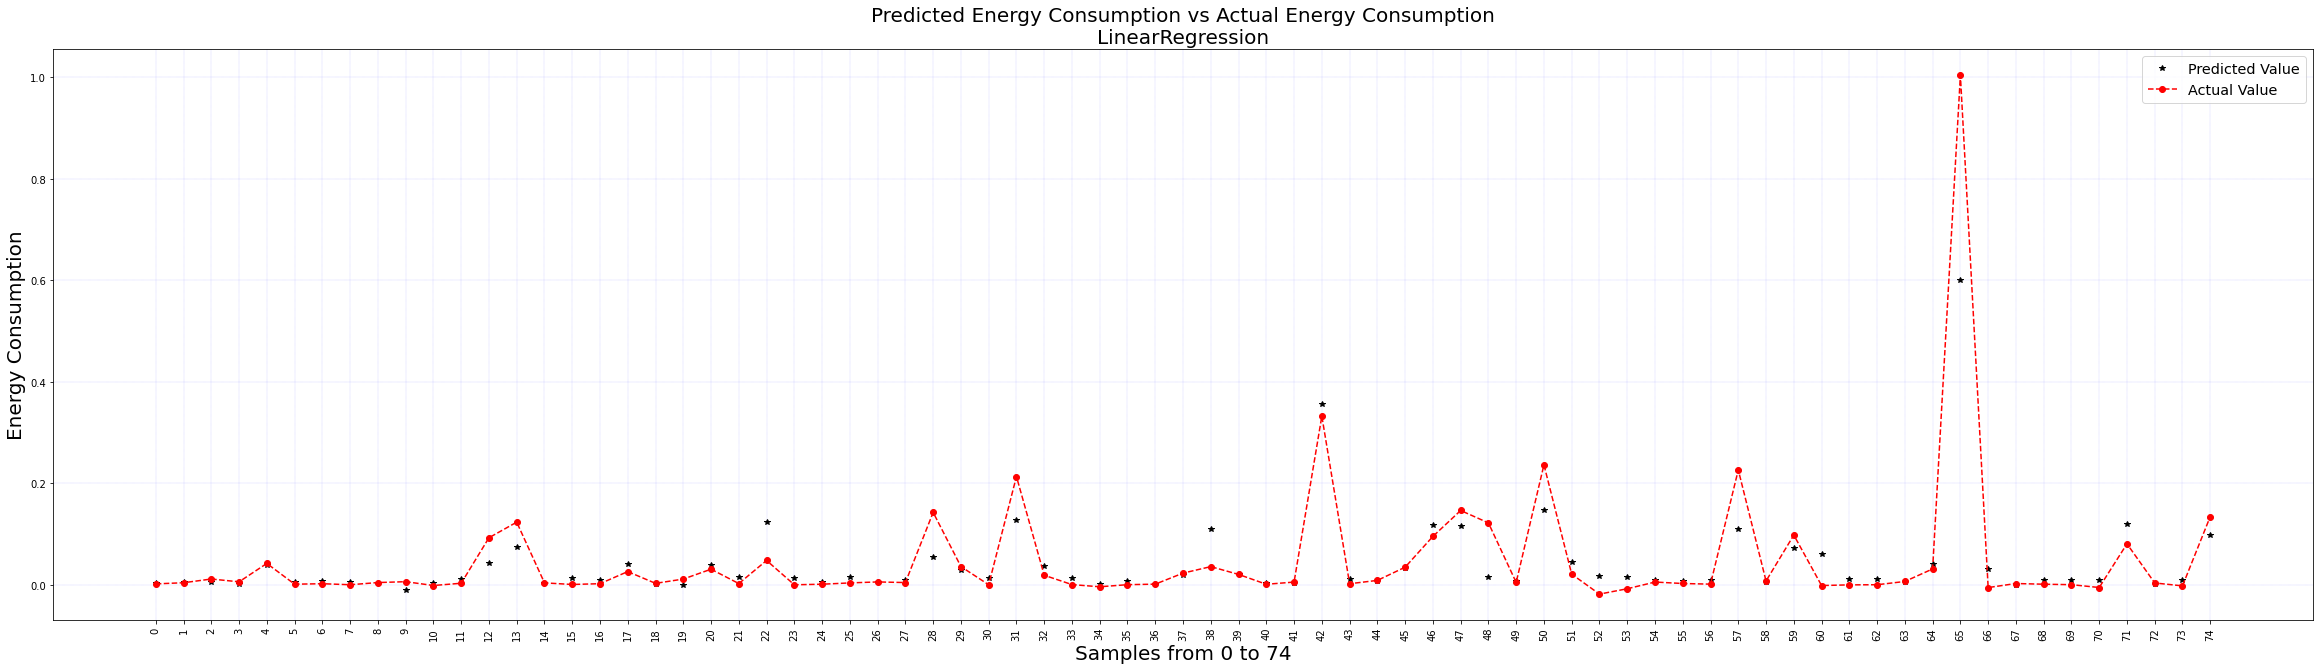

In [37]:
#Prediction with a Linear Regression Model
Model_Name
PredictedValues = LinearRegression_Model()
Actual_Values = y_test
Count = 75             #Indicates Plotting for how many samples
Plotting_Pred_Actual(Model_Name,Actual_Values,PredictedValues,Length_of_TestData,Count,75)


/content/hdemma.github.io/Dataset/PredictionModels/Electric
MSE		MAE
Tarining Set Loss: [0.03301704207592966, 0.03147962689399719]
Testing Set Loss: [0.03119445630752426, 0.03148137032985687]


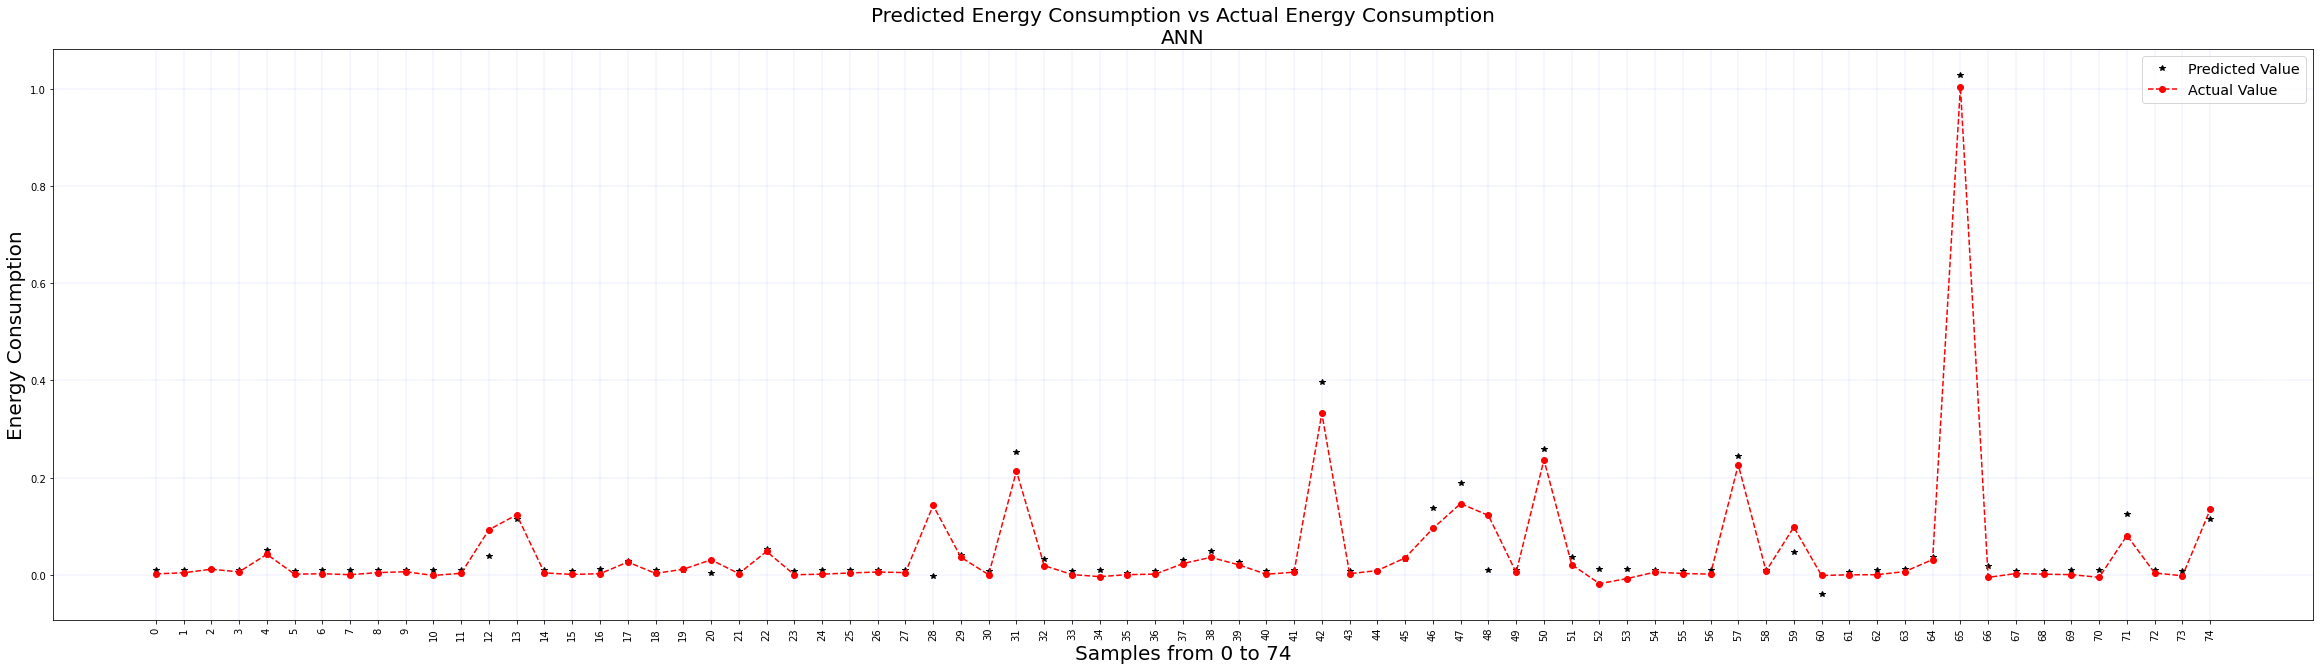

In [39]:
#Prediction with a ANN
Model_Name='ANN'
PredictedValues_FF = SimpleFeedForward_Model()
Actual_Values = y_test
PredictedValues = []
for i in PredictedValues_FF:
    for j in i:
        PredictedValues.append(j)

Count = 75             #Indicates Plotting for how many samples
Plotting_Pred_Actual(Model_Name,Actual_Values,PredictedValues,Length_of_TestData,Count,75)

/content/hdemma.github.io/Dataset/PredictionModels/Electric
R^2 Score = 0.17647631220867477


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


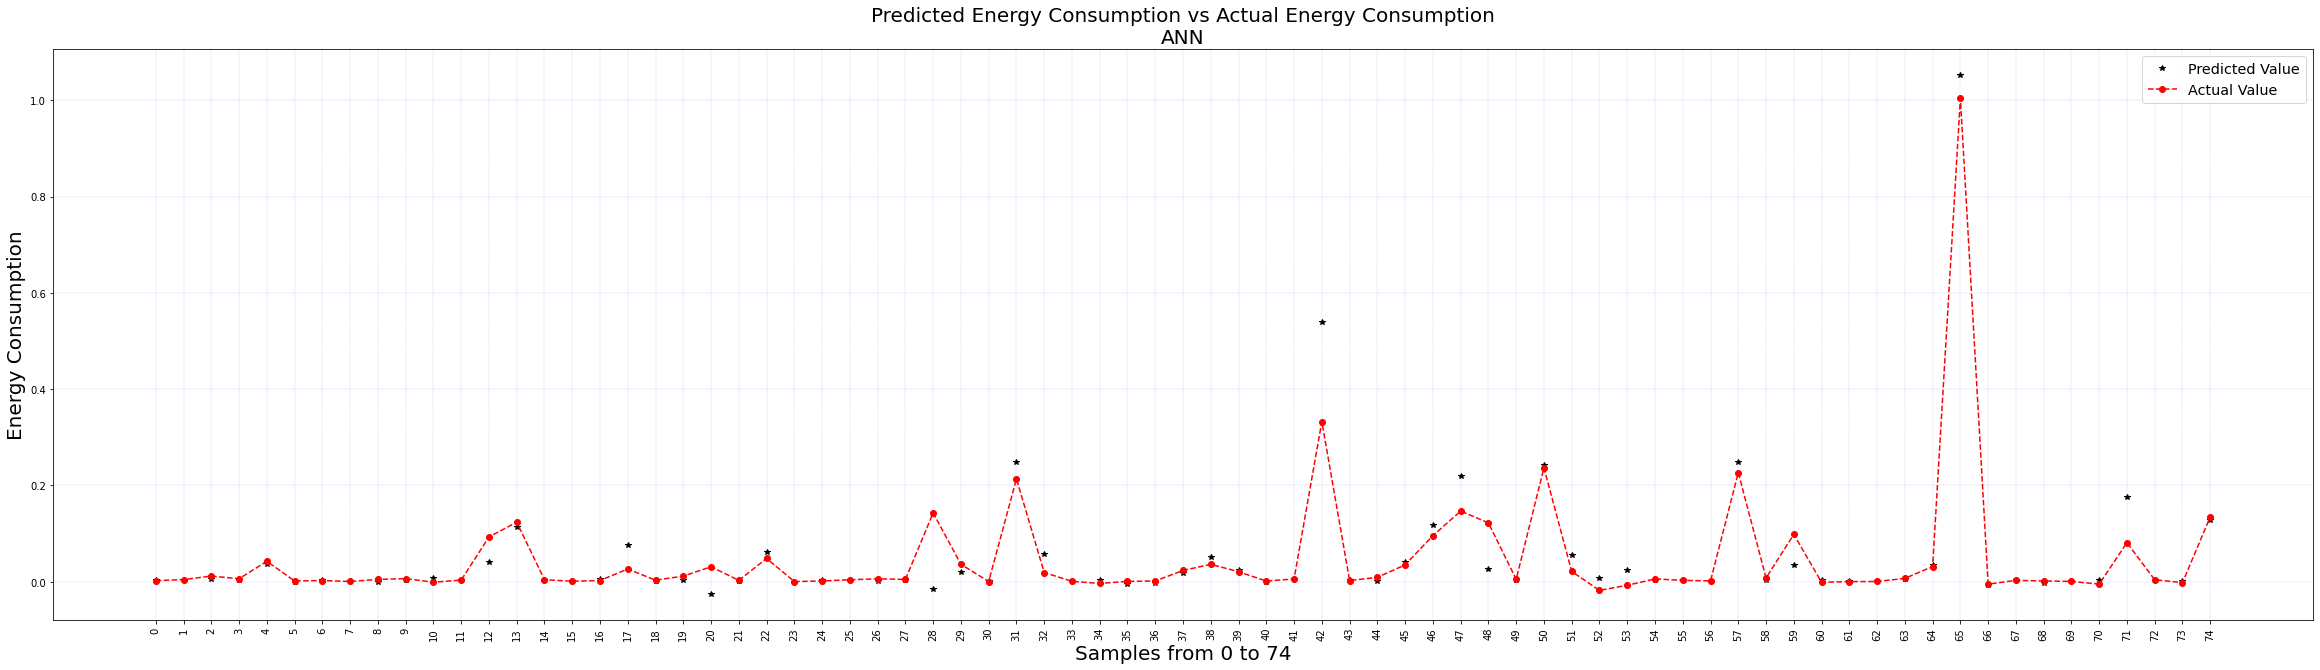

In [40]:
#Prediction with a Decision Tree
Model_Name
PredictedValues = DecisionTree_Model()
Actual_Values = y_test
Count = 75             #Indicates Plotting for how many samples
Plotting_Pred_Actual(Model_Name,Actual_Values,PredictedValues,Length_of_TestData,Count,75)

# MSE Plot

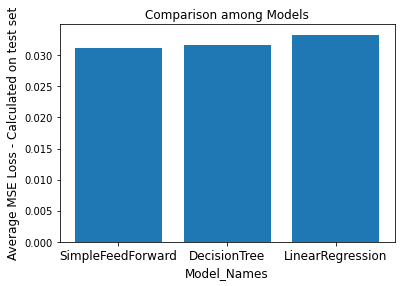

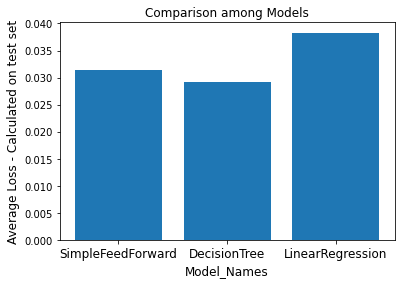

In [0]:
Vehicle_Type = 'Electric_Vehicles'
Model_Names = ['SimpleFeedForward', 'DecisionTree', 'LinearRegression']

LOSS = []
MSE_Loss = []
Error_in_Percentage = []
for Model_Name in Model_Names:
    df = pd.read_csv(
        f'https://raw.githubusercontent.com/hdemma/hdemma.github.io/develop/Dataset/Results/Electric/{Model_Name}_Predicted_Fuel_Consumption_for_{Vehicle_Type}.csv')

    Actual_Values = df.Actual_Values
    Avg_Loss_df = df.Abs_Loss
    Predicted_Values = df.Predicted_Values

    

    MSE = mean_squared_error(Actual_Values, Predicted_Values)
    MSE_Loss.append(MSE)
    LOSS.append(Avg_Loss_df.mean())
    Error_in_Percentage.append(Avg_Loss_df.mean()/Actual_Values.mean()*100)
    




import matplotlib.pyplot as plt


plt.bar(Model_Names, MSE_Loss)
plt.xticks(Model_Names, size=12)
plt.title("Comparison among Models")
plt.xlabel("Model_Names", size=12)
plt.ylabel("Average MSE Loss - Calculated on test set", size=12)

plt.show()

plt.bar(Model_Names, LOSS)
plt.xticks(Model_Names, size=12)
plt.title("Comparison among Models")
plt.xlabel("Model_Names", size=12)
plt.ylabel("Average Loss - Calculated on test set", size=12)
plt.show()


